# Training Trainers
### Authors: Nigel Nelson and Collin Quinn - 2/15/22
---
## Introduction:
- Staying healthy and injury free as an athlete is vital for success. While in some sports (i.e. soccer, football), injuries often can be unpredictable, individual endurance sports such as running (which this data set is based around), in which overuse injuries are the most prevalent, may be better suited for accurate injury prediction. The end goal of this project would eventually be for coaches to be able to use this model, along with that individual’s previous injury history, to be able to efficiently schedule workouts in a way that minimizes the risk of injury.

## Research Questions:
- What features are most predictive of injuries in long distance runners
- Can a injury prediction model be made accurate enough to provide meaningful insight on training protocols

## Hypothesis: 
- The greater the perceived exertion an athlete reports, the higher the probability that later training sessions result in injury

## The Dataset:
- The data set consists of a detailed training log from a Dutch high-level running team over a period of seven years (2012-2019). Included are the middle and long distance runners of the team, that is, those competing on distances between the 800 meters and the marathon. This design decision is motivated by the fact that these groups have strong endurance based components in their training, making their training regimes comparable. 
- The data set contains 42,766 entries from 74 runners, of whom 27 are women and 47 are men. 583 injuries were recorded, which means that about 98% of the data set's entries were non-injuries.  
    - Each entry in the data set corresponds to a single athlete and a week of their training which is comprised of 10 features recorded for 7 days leading up to a potential injury. 
    - The 10 daily features are: Number of training sessions, total distance ran, distance ran at low heart rate intensity, distance ran at medium heart rate intensity, distance ran at high heart rate intensity, number of strength training sessions, hours of alternative training (such as cycling or swimming), percieved exertion (how exhausted the athlete at completion of training), percieved training success (how well the athlete felt training went that day), perceived recovery (how recovered the athlete felt before beginning training), and a lastly an injury flag that indicates whether the 7 days of training recorded resulted in in injury that prevented the athlete from completing a training session.
    

- Source: https://dataverse.nl/dataset.xhtml?persistentId=doi:10.34894/UWU9PV


### Imports:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpy as np
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.metrics import roc_auc_score

---
## Data Preprocessing:


#### Loading the Data Set:
- Discrete features are loaded as categorical features
- Running intensity features are converted to more readable column names for greater interpretability
- Non-useful columns are dropped, such as Date and Athlete ID
- Note: There were not any empty values in the data set

In [2]:
day_data = pd.read_csv("dataverse_files\day_approach_maskedID_timeseries.csv",
                        dtype={'nr. sessions': 'category',
                                'nr. sessions.1': 'category',
                                'nr. sessions.2': 'category',
                                'nr. sessions.3': 'category',
                                'nr. sessions.4': 'category',
                                'nr. sessions.5': 'category',
                                'nr. sessions.6': 'category',
                                'strength training': 'category',
                                'strength training.1': 'category',
                                'strength training.2': 'category',
                                'strength training.3': 'category',
                                'strength training.4': 'category',
                                'strength training.5': 'category',
                                'strength training.6': 'category',
                                'injury': 'category'})

day_data = day_data.drop(columns=['Date', 'Athlete ID'])

for suffix in ["", ".1", ".2", ".3", ".4", ".5", ".6"]:
    km_Z3 = 'km Z3-4' + suffix
    km_Z5 = 'km Z5-T1-T2' + suffix
    km_sprinting = 'km sprinting' + suffix
    low_inten = 'km low-intensity' + suffix
    med_inten = 'km medium-intensity' + suffix
    hgih_inten = 'km high-intensity' + suffix

    day_data.rename(columns = {km_Z3: low_inten,
                            km_Z5: med_inten,
                            km_sprinting: hgih_inten},
                            inplace = True)

day_data.head()

,nr. sessions,total km,km low-intensity,km medium-intensity,km high-intensity,strength training,hours alternative,perceived exertion,perceived trainingSuccess,perceived recovery,...,total km.6,km low-intensity.6,km medium-intensity.6,km high-intensity.6,strength training.6,hours alternative.6,perceived exertion.6,perceived trainingSuccess.6,perceived recovery.6,injury
0,1.0,5.8,0.0,0.6,1.2,0.0,0.00,0.11,0.00,0.18,...,0.0,0.0,0.0,0.0,0.0,1.0,0.10,0.00,0.15,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.00,-0.01,-0.01,-0.01,...,5.2,0.0,0.5,1.2,0.0,0.0,0.10,0.00,0.17,0
2,1.0,0.0,0.0,0.0,0.0,1.0,0.00,0.10,0.00,0.17,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.01,-0.01,-0.01,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.00,-0.01,-0.01,-0.01,...,0.0,0.0,0.0,0.0,1.0,0.0,0.10,0.00,0.17,0
4,1.0,0.0,0.0,0.0,0.0,0.0,1.08,0.08,0.00,0.18,...,17.6,7.2,0.0,0.0,0.0,0.0,0.11,0.00,0.17,0


In [3]:
day_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42766 entries, 0 to 42765
Data columns (total 71 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   nr. sessions                 42766 non-null  category
 1   total km                     42766 non-null  float64 
 2   km low-intensity             42766 non-null  float64 
 3   km medium-intensity          42766 non-null  float64 
 4   km high-intensity            42766 non-null  float64 
 5   strength training            42766 non-null  category
 6   hours alternative            42766 non-null  float64 
 7   perceived exertion           42766 non-null  float64 
 8   perceived trainingSuccess    42766 non-null  float64 
 9   perceived recovery           42766 non-null  float64 
 10  nr. sessions.1               42766 non-null  category
 11  total km.1                   42766 non-null  float64 
 12  km low-intensity.1           42766 non-null  float64 
 13  k

---
## Data Analysis and Visualization:
- Each of the features are analyzed using statistical test in order to determine which features have the greatest statistical significance. Continous features are evaluated using the Kruskal Wallis test, while the categorical features are evaluated using chi square contingency test.

In [4]:
pvalues = {}

continuous_features = ['total km', 'km low-intensity', 'km medium-intensity', 'km high-intensity', 'hours alternative',
'perceived exertion', 'perceived trainingSuccess', 'perceived recovery']

categorical_features = ['nr. sessions', 'strength training']

for feature in continuous_features:
    for suffix in ["", ".1", ".2", ".3", ".4", ".5", ".6"]:
        col = feature + suffix
        samples_by_group = []
        for value in set(day_data["injury"]):
            mask = day_data["injury"] == value
            samples_by_group.append(day_data[col][mask])
        stat, p = stats.kruskal(*samples_by_group)
        pvalues[col] = p

for feature in categorical_features:
    for suffix in ["", ".1", ".2", ".3", ".4", ".5", ".6"]:
        col = feature + suffix
        combination_counts = day_data.value_counts(subset=["injury", col]).unstack(level=0).fillna(0)
        chi2, p, _, _ = stats.chi2_contingency(combination_counts)
        pvalues[col] = p

### Plotting feature P-values:
- P-values are plotted from least to greatest. In order to control the familywise error rate, a Bonferroni Corrrection is applied to an initial alpha of 0.01 to get a final alpha value of ~0.000143.

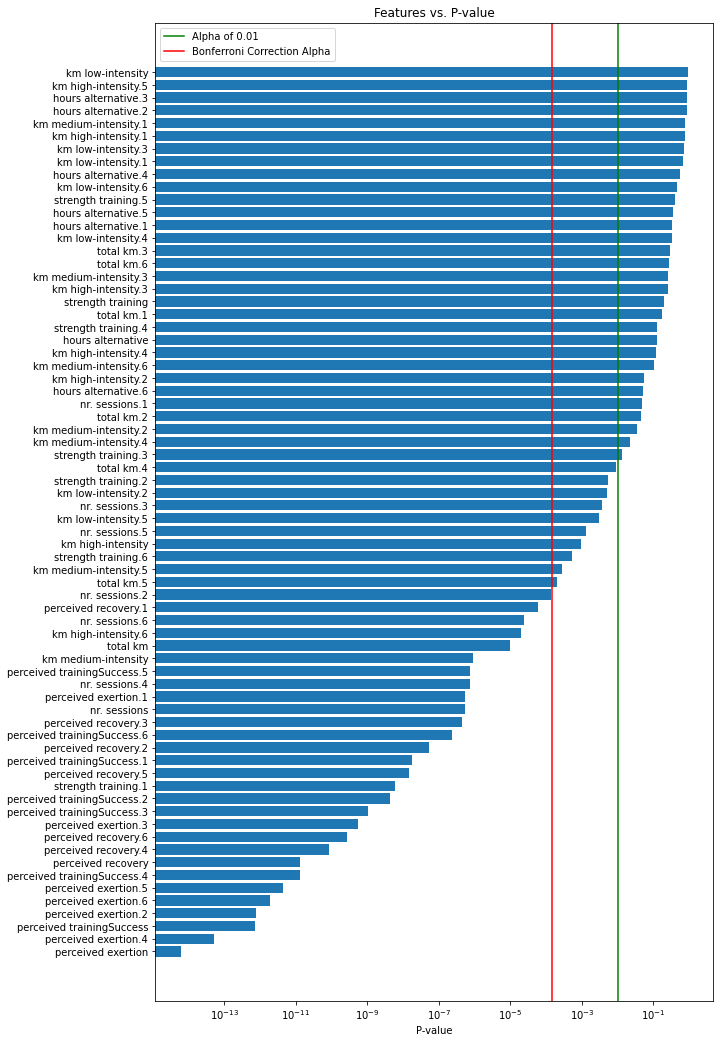

In [5]:
pvalues = dict(sorted(pvalues.items(), key=lambda item: item[1], reverse=True))

fig, ax = plt.subplots()

features = pvalues.keys()
y_pos = np.arange(len(features))

ax.barh(y_pos, pvalues.values(), align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(features)
ax.invert_yaxis()
ax.set_xlabel('P-value')
ax.set_title('Features vs. P-value')
ax.set_xscale('log')
fig.set_size_inches(10, 18)

plt.axvline(x=0.01, c='g', label="Alpha of 0.01")
plt.axvline(x=0.01/70, c='r', label="Bonferroni Correction Alpha")
plt.legend()

### Applying Bonferroni Correction
- The Bonferroni correction method was chosen to control the familywise error rate. Below is a DataFrame displaying the statistically significant features.

In [6]:
stat_sig_features = []
for feat, pvalue in pvalues.items():
    if pvalue < .01/70:
        stat_sig_features.append(feat)

sig_features = day_data[stat_sig_features]
sig_features.head()

,nr. sessions.2,perceived recovery.1,nr. sessions.6,km high-intensity.6,total km,km medium-intensity,perceived trainingSuccess.5,nr. sessions.4,perceived exertion.1,nr. sessions,...,perceived recovery.6,perceived recovery.4,perceived recovery,perceived trainingSuccess.4,perceived exertion.5,perceived exertion.6,perceived exertion.2,perceived trainingSuccess,perceived exertion.4,perceived exertion
0,1.0,-0.01,1.0,0.0,5.8,0.6,0.00,1.0,-0.01,1.0,...,0.15,0.18,0.18,0.00,0.11,0.10,0.10,0.00,0.08,0.11
1,0.0,0.17,1.0,1.2,0.0,0.0,0.00,1.0,0.10,0.0,...,0.17,0.17,-0.01,0.00,0.10,0.10,-0.01,-0.01,0.11,-0.01
2,1.0,-0.01,0.0,0.0,0.0,0.0,0.00,1.0,-0.01,1.0,...,-0.01,0.15,0.17,0.00,0.10,-0.01,0.08,0.00,0.10,0.10
3,1.0,0.18,1.0,0.0,0.0,0.0,-0.01,1.0,0.08,0.0,...,0.17,0.17,-0.01,0.00,-0.01,0.10,0.11,-0.01,0.10,-0.01
4,1.0,0.17,1.0,0.0,0.0,0.0,0.00,0.0,0.11,1.0,...,0.17,-0.01,0.18,-0.01,0.10,0.11,0.10,0.00,-0.01,0.08


### Exploring our Hypothesis:
- While the statistical tests confirm that the perceived exertion feature is statistically significant in predicting injuries, it does not tell us the direction of the relationship between perceived exertion and injuries. The Kruskal-Wallis test was used on this feature, so all that is known for certain, is that the difference in the mean perceived exertion for injured vs. non-injured training logs is statistically sigificant. In order to explore the direction of this relationship, the Pearson Correlation Coefficient can be used:

In [7]:
day_data[['perceived exertion', 'injury']].astype('float64').corr()

,perceived exertion,injury
perceived exertion,1.000000,0.039748
injury,0.039748,1.000000


### Hypothesis Analysis:
- While the Pearson Correlation Coefficient for injury and perceived exertion is small, it is positive. So, with the information from the Kruskal-Wallis test, and now the Pearson Correlation Coefficient, it can be concluded that our hypothesis is true, the greater the perceived exertion an athlete reports, the higher the probability that later training sessions result in injury.

---
### Plotting the most predictive features:

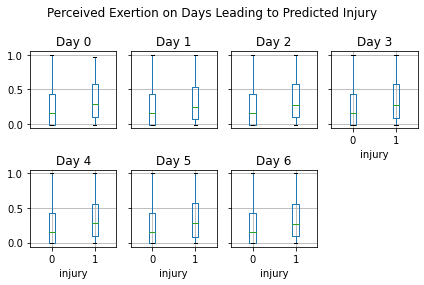

In [8]:
fig, ax = plt.subplots(2, 4, sharey='row')
i = 0
for suffix in ["", ".1", ".2", ".3", ".4", ".5", ".6"]:
    col = "perceived exertion" + suffix
    day_data.boxplot(column=col, by='injury', ax=ax.flatten()[i])
    ax.flatten()[i].title.set_text(f'Day {i}')

    i = i + 1

ax[1,3].axis('off')
ax[0,0].set_xticks([])
ax[0,1].set_xticks([])
ax[0,2].set_xticks([])
ax[0,0].set_xlabel("")
ax[0,1].set_xlabel("")
ax[0,2].set_xlabel("")
plt.suptitle('Perceived Exertion on Days Leading to Predicted Injury')
plt.tight_layout()

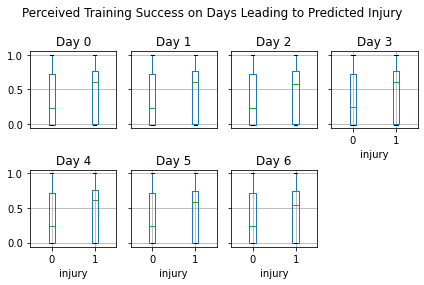

In [9]:
fig, ax = plt.subplots(2, 4, sharey='row')
i = 0
for suffix in ["", ".1", ".2", ".3", ".4", ".5", ".6"]:
    col = "perceived trainingSuccess" + suffix
    day_data.boxplot(column=col, by='injury', ax=ax.flatten()[i])
    ax.flatten()[i].title.set_text(f'Day {i}')

    i = i + 1

ax[1,3].axis('off')
ax[0,0].set_xticks([])
ax[0,1].set_xticks([])
ax[0,2].set_xticks([])
ax[0,0].set_xlabel("")
ax[0,1].set_xlabel("")
ax[0,2].set_xlabel("")

plt.suptitle('Perceived Training Success on Days Leading to Predicted Injury')
plt.tight_layout()

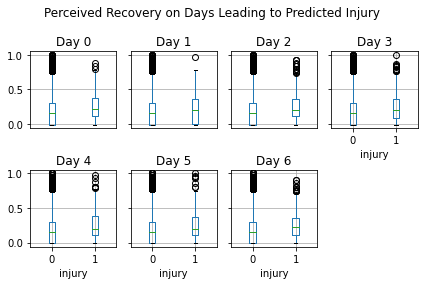

In [10]:
fig, ax = plt.subplots(2, 4, sharey='row')
i = 0
for suffix in ["", ".1", ".2", ".3", ".4", ".5", ".6"]:
    col = "perceived recovery" + suffix
    day_data.boxplot(column=col, by='injury', ax=ax.flatten()[i])
    ax.flatten()[i].title.set_text(f'Day {i}')

    i = i + 1

ax[1,3].axis('off')
ax[0,0].set_xticks([])
ax[0,1].set_xticks([])
ax[0,2].set_xticks([])
ax[0,0].set_xlabel("")
ax[0,1].set_xlabel("")
ax[0,2].set_xlabel("")

plt.suptitle('Perceived Recovery on Days Leading to Predicted Injury')
plt.tight_layout()

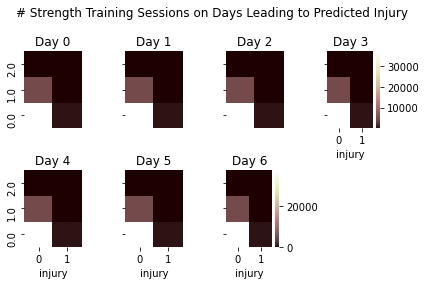

In [11]:
fig, ax = plt.subplots(2, 4, sharey='row')
i = 0
for suffix in ["", ".1", ".2", ".3", ".4", ".5", ".6"]:
    col = "strength training" + suffix
    injury_strength_count = day_data[[col, 'injury']].groupby(
    [col, 'injury']).size().unstack(-1).fillna(0)
    if i in [3, 6]:
        sns.heatmap(injury_strength_count, cmap='pink', ax=ax.flatten()[i])
    else:
        sns.heatmap(injury_strength_count, cmap='pink', ax=ax.flatten()[i], cbar=False)
    ax.flatten()[i].title.set_text(f'Day {i}')
    ax.flatten()[i].set_ylabel("")
    ax.flatten()[i].invert_yaxis()
    i += 1

ax[1,3].axis('off')
ax[0,0].set_xticks([])
ax[0,1].set_xticks([])
ax[0,2].set_xticks([])
ax[0,0].set_xlabel("")
ax[0,1].set_xlabel("")
ax[0,2].set_xlabel("")
plt.suptitle('# Strength Training Sessions on Days Leading to Predicted Injury')
plt.tight_layout()

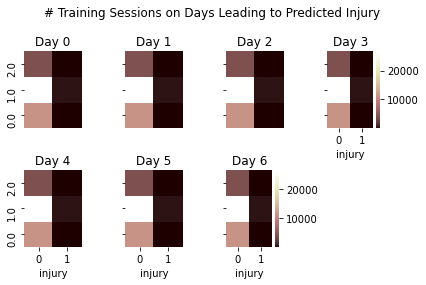

In [12]:
fig, ax = plt.subplots(2, 4, sharey='row')
i = 0
for suffix in ["", ".1", ".2", ".3", ".4", ".5", ".6"]:
    col = "nr. sessions" + suffix
    injury_session_count = day_data[[col, 'injury']].groupby(
    [col, 'injury']).size().unstack(-1).fillna(0)
    if i in [3, 6]:
        sns.heatmap(injury_session_count, cmap='pink', ax=ax.flatten()[i])
    else:
        sns.heatmap(injury_session_count, cmap='pink', ax=ax.flatten()[i], cbar=False)
    ax.flatten()[i].title.set_text(f'Day {i}')
    ax.flatten()[i].set_ylabel("")
    ax.flatten()[i].invert_yaxis()
    i += 1

ax[1,3].axis('off')
ax[0,0].set_xticks([])
ax[0,1].set_xticks([])
ax[0,2].set_xticks([])
ax[0,0].set_xlabel("")
ax[0,1].set_xlabel("")
ax[0,2].set_xlabel("")
plt.suptitle('# Training Sessions on Days Leading to Predicted Injury')
plt.tight_layout()

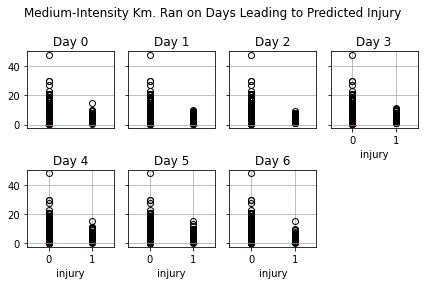

In [13]:

fig, ax = plt.subplots(2, 4, sharey='row')
i = 0
for suffix in ["", ".1", ".2", ".3", ".4", ".5", ".6"]:
    col = "km medium-intensity" + suffix
    day_data.boxplot(column=col, by='injury', ax=ax.flatten()[i])
    ax.flatten()[i].title.set_text(f'Day {i}')

    i = i + 1

ax[1,3].axis('off')
ax[0,0].set_xticks([])
ax[0,1].set_xticks([])
ax[0,2].set_xticks([])
ax[0,0].set_xlabel("")
ax[0,1].set_xlabel("")
ax[0,2].set_xlabel("")

plt.suptitle('Medium-Intensity Km. Ran on Days Leading to Predicted Injury')
plt.tight_layout()


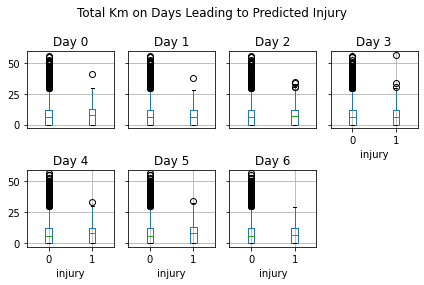

In [14]:
fig, ax = plt.subplots(2, 4, sharey='row')
i = 0
for suffix in ["", ".1", ".2", ".3", ".4", ".5", ".6"]:
    col = "total km" + suffix
    day_data.boxplot(column=col, by='injury', ax=ax.flatten()[i])
    ax.flatten()[i].title.set_text(f'Day {i}')

    i = i + 1

ax[1,3].axis('off')
ax[0,0].set_xticks([])
ax[0,1].set_xticks([])
ax[0,2].set_xticks([])
ax[0,0].set_xlabel("")
ax[0,1].set_xlabel("")
ax[0,2].set_xlabel("")

plt.suptitle('Total Km on Days Leading to Predicted Injury')
plt.tight_layout()

### Data Visualization Analysis:
From the above plots of the most statistically significant features, two things are clear, first, there are some features that do visually separate injuries vs. non-injuries, second, the features suffer overall from the unbalanced nature of the data set. Beginning with perceived exertion, it is clear that while extreme separation is not seen, athletes with higher perceived exertion were more likely to be injured. This is an unsurprising result as perceived exertion is a qualitative measure of how hard a day of training was, where its logically more likely to get injured on a hard training day than a light training day. As for perceived training success, the results were somewhat surprising. It would make sense that a soon to be injured athlete would show signs of decline before an injury, and thus have poor training success. However, the mean perceived training success for athletes that got injured was actually higher than athletes that did not get injured. This could be due to the fact that for many athletes, training success is likely a measure of how hard they worked during the training day, in which it may somewhat mirror perceived training exertion. For perceived recovery, this boxplot also introduced a surprising result. The mean perceived recovery of athletes that got injured was actually higher than those who did not get injured. This is surprising as you would expect that there would be early signs of an injury, where an athlete may be feeling weak in the future injury location. However, this may be explainable by the fact that highly recovered athletes may take greater risks, which could result in injuries, whereas unrecovered athletes likely try to lay low in their training and just go through the motions. As for the remaining plots, the limitations that the unbalanced data set imposes on the features becomes clear. For nr. sessions, and # strength training sessions, the heatmaps make it clear how few injuries occurred, and beyond that only illustrate that athletes more often than not had one daily training session, and did not have a single *strength* training session. In addition, the km. medium-intensity and total km. features show similar training patterns for both injuries and non-injuries, with dozens of outliers mixed in. The common themes seen in nr. sessions, # strength training sessions, km medium-intensity, and total km are all indications of the fact that this data set came from a **single** team. All of the features have very similar distributions between the groups, and this is likely due to the fact that training decisions were not made individually, instead, coaches likely assigned blanket requirements for training, where each athlete was expected to train a certain way, for a certain duration, no more, no less. This would ultimately explain why the 'perceived' group of features were more predictive than the others. The 'perceived' features were unique to the individual, whereas the training features likely had more to due with a coaches decisions, than whether or not an athlete was soon to be injured.

---
## Data Modeling and Prediction

In this part, we are first utilizng a random forest classification model. In the first part (unbalanced models), we are randomly sampling from the data set. It is important to keep in mind that 98% of the data set's entries were non-injuries. In part 2, we are using a balanced model, where we have an equal amount of injuries and non-injuries.

---
### Part 1: **Unbalanced** Models:

#### Train/Test Split for All features (unbalanced training data set)

In [15]:
df_train, df_test = train_test_split(day_data, stratify=day_data["injury"], random_state=42)
y_train = df_train["injury"]
y_test = df_test["injury"]
X_train = df_train.drop(columns='injury')
X_test = df_test.drop(columns='injury')

scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

### Train a Random Forest Classifier with ALL features

F1 Score:  0.49656276485544776
Top 3 predictive features...
perceived exertion.3
perceived recovery.5
perceived exertion.2


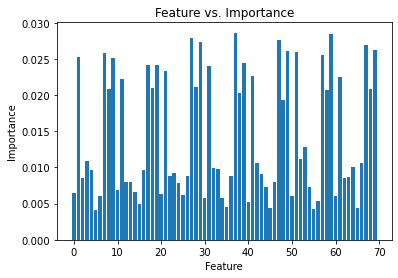

In [16]:
nums = {}
pred_feat_names = []
# define the model
model = RandomForestClassifier()
# fit the model
model.fit(scaled_X_train, y_train)
# get importance
importance = model.feature_importances_

y_pred_rf2=model.predict(scaled_X_test)

f1_Score = f1_score(y_test, y_pred_rf2, average='macro')

print("F1 Score: ", f1_Score)

# summarize feature importance
for i,v in enumerate(importance):
    nums[i] = v

print('Top 3 predictive features...')

for x in range(0,3):
    max_key = max(nums, key=nums.get)
    colname = day_data.columns[max_key]
    pred_feat_names.append(colname)
    print(colname)
    del nums[max_key]

# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature vs. Importance')
pyplot.show()

#### Plot the top 2 most predictive features

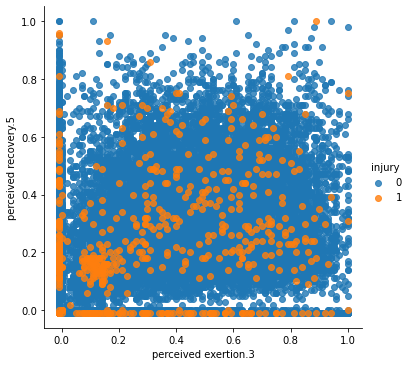

In [17]:
sns.lmplot(x=pred_feat_names[0], y=pred_feat_names[1], data=day_data, hue='injury',fit_reg=False)
plt.show()

From the plot above, it can be assessed that it would be difficult to obtain a linear separation from class 0 vs. class 1.

### Training Random Forest Classifier with feature selection

In this part, we are using feature selection with a random forest classifier, where we take the top 3 most predictive features to create a new model. 

In [18]:
day_data_new = day_data[[pred_feat_names[0], pred_feat_names[1], pred_feat_names[2], 'injury']].copy()
df_train_fs, df_test_fs = train_test_split(day_data_new, stratify=day_data_new["injury"], random_state=42)
y_train_fs = df_train_fs["injury"]
y_test_fs = df_test_fs["injury"]
X_train_fs = df_train_fs.drop(columns='injury')
X_test_fs = df_test_fs.drop(columns='injury')

scaler = StandardScaler()
scaled_X_train_fs = scaler.fit_transform(X_train_fs)
scaled_X_test_fs = scaler.transform(X_test_fs)

F1 Score:  0.4960882269770949
Top 3 predictive features...
perceived recovery.5
perceived exertion.2
perceived exertion.3


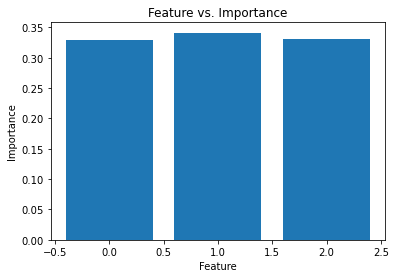

In [19]:
nums = {}
model_fs = RandomForestClassifier()

model_fs.fit(scaled_X_train_fs, y_train_fs)
# get importance
importance_fs = model_fs.feature_importances_

y_pred_rf2=model_fs.predict(scaled_X_test_fs)

f1_Score = f1_score(y_test_fs, y_pred_rf2, average='macro')

print("F1 Score: ", f1_Score)

# summarize feature importance
for i,v in enumerate(importance_fs):
    nums[i] = v
    
    
print('Top 3 predictive features...')

for x in range(0,3):
    max_key = max(nums, key=nums.get)
    colname = day_data_new.columns[max_key]
    print(colname)
    del nums[max_key]

# plot feature importance
pyplot.bar([x for x in range(len(importance_fs))], importance_fs)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature vs. Importance')
pyplot.show()

Plot the top two most predictive features. 

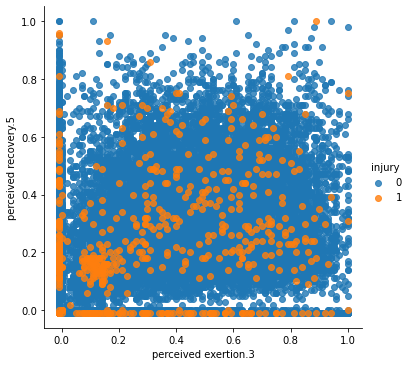

In [20]:
sns.lmplot(x=pred_feat_names[0], y=pred_feat_names[1], data=day_data, hue='injury',fit_reg=False)
plt.show()

From the plot above, it can be assessed that it would be difficult to obtain a linear separation from class 0 vs. class 1.

**Part 1 Analysis:** From the unbalanced models, it can be assessed that our unbalanced data set is causing our model with all features, along with our model with feature selection to give us essentially identical F1 score values. This is not desired, and is almost certainly because ~98% of the data set's entries are non-injuries. 

---
### Part 2: **Balanced** Models:

**Part 2a**: Since our data set is very unbalanced (98% of rows are non-injuries), a balanced random forest classification model was created sing 2,000 labels, and we achieved an F1 score of ~88%.

In [21]:
all_injuries = y_train.astype('int32') == 1
indexes = []
for idx, val in enumerate(all_injuries):
    indexes.append(val or idx <= 2000)
temp_X_train = X_train[indexes]
temp_y_train = y_train[indexes]
categorical_features = ['nr. sessions', 'strength training']
for feature in categorical_features:
    for suffix in ["", ".1", ".2", ".3", ".4", ".5", ".6"]:
        col = feature + suffix
        temp_X_train[col] = temp_X_train[col].astype('float64').astype('int64')

print('Original dataset shape %s' % Counter(temp_y_train))
sm = SMOTE(random_state=42)
X_sm, y_sm = sm.fit_resample(temp_X_train, temp_y_train)

print('Resampled dataset shape %s' % Counter(y_sm))
for feature in categorical_features:
    for suffix in ["", ".1", ".2", ".3", ".4", ".5", ".6"]:
        col = feature + suffix
        X_sm[col] = X_sm[col].astype('category')

Original dataset shape Counter({'0': 1981, '1': 437})
Resampled dataset shape Counter({'0': 1981, '1': 1981})


<ipython-input-21-5ff818c7f239>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_X_train[col] = temp_X_train[col].astype('float64').astype('int64')


In [22]:
print('Value Counts for labels:\n', y_sm.value_counts())
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, random_state=42)
scaler = StandardScaler()
scaled_X_train_2000 = scaler.fit_transform(X_train)
scaled_X_test_2000 = scaler.transform(X_test)

Value Counts for labels:
 0    1981
1    1981
Name: injury, dtype: int64


F1 Score:  0.8804754895948321
Top 3 predictive features...
perceived trainingSuccess.5
perceived trainingSuccess.6
perceived trainingSuccess


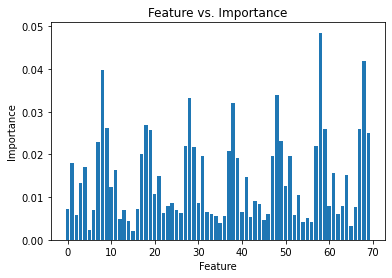

In [23]:
nums_bal = {}
pred_feat_names_bal = []
# define the model
model_bal = RandomForestClassifier()
# fit the model
model_bal.fit(scaled_X_train_2000, y_train)

# get importance
importance_bal = model_bal.feature_importances_

y_pred_bal_2000=model_bal.predict(scaled_X_test_2000)

f1_score_2000 = f1_score(y_test, y_pred_bal_2000, average='macro')

print("F1 Score: ", f1_score_2000)

# summarize feature importance
for i,v in enumerate(importance_bal):
    nums_bal[i] = v

print('Top 3 predictive features...')

for x in range(0,3):
    max_key = max(nums_bal, key=nums_bal.get)
    colname = day_data.columns[max_key]
    pred_feat_names_bal.append(colname)
    print(colname)
    del nums_bal[max_key]

# plot feature importance
pyplot.bar([x for x in range(len(importance_bal))], importance_bal)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature vs. Importance')
pyplot.show()

**Part 2b:** Using an event amount of labels (42,183) instead of 2000. As can be seen below, the f1 score ends up being around 99%.

In [24]:
X = day_data.drop(columns=['injury'])
y = day_data['injury']

In [25]:
# SMOTE: https://www.kaggle.com/ktattan/recall-97-with-smote-random-forest-tsne

categorical_features = ['nr. sessions', 'strength training']
for feature in categorical_features:
    for suffix in ["", ".1", ".2", ".3", ".4", ".5", ".6"]:
        col = feature + suffix
        X[col] = X[col].astype('float64').astype('int64')

smote=SMOTE(random_state=42)

X_sm , y_sm = smote.fit_resample(X,y)

categorical_features = ['nr. sessions', 'strength training']
for feature in categorical_features:
    for suffix in ["",".1", ".2", ".3", ".4", ".5", ".6"]:
        col = feature + suffix
        X_sm[col] = X_sm[col].astype('float64').astype('int64').astype('category')

print('Value Counts for labels:\n', y_sm.value_counts())
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, random_state=42)

scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

Value Counts for labels:
 0    42183
1    42183
Name: injury, dtype: int64


F1 Score:  0.9908946286217934
Top 3 predictive features...
perceived trainingSuccess.6
perceived trainingSuccess
perceived trainingSuccess.3


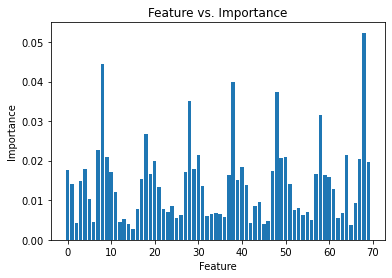

In [26]:
nums_bal = {}
pred_feat_names_bal = []
# define the model
model_bal = RandomForestClassifier()
# fit the model
model_bal.fit(scaled_X_train, y_train)

# get importance
importance_bal = model_bal.feature_importances_

y_pred_bal=model_bal.predict(scaled_X_test)

f1_Score = f1_score(y_test, y_pred_bal, average='macro')

print("F1 Score: ", f1_Score)

# summarize feature importance
for i,v in enumerate(importance_bal):
    nums_bal[i] = v

print('Top 3 predictive features...')

for x in range(0,3):
    max_key = max(nums_bal, key=nums_bal.get)
    colname = X_train.columns[max_key]
    pred_feat_names_bal.append(colname)
    print(colname)
    del nums_bal[max_key]

# plot feature importance
pyplot.bar([x for x in range(len(importance_bal))], importance_bal)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature vs. Importance')
pyplot.show()

In [27]:
pred_proba = model_bal.predict_proba(scaled_X_test)
auc_score1 = roc_auc_score(y_test, pred_proba[:,1])
print('Auc score: ',auc_score1)

Auc score:  0.9972481656798253


**Part 2c:** Using 2000 labels, with feature selection. As can be seen below, the f1 score ends up being around 77%

In [28]:
all_injuries = y_train_fs.astype('int32') == 1
indexes = []
for idx, val in enumerate(all_injuries):
    indexes.append(val or idx <= 2000)
temp_X_train_fs = X_train_fs[indexes]
temp_y_train_fs = y_train_fs[indexes]


print('Original dataset shape %s' % Counter(temp_y_train_fs))
sm = SMOTE(random_state=42)
X_sm_fs, y_sm_fs = sm.fit_resample(temp_X_train_fs, temp_y_train_fs)

print('Resampled dataset shape %s' % Counter(y_sm_fs))
X_sm_fs.info()

Original dataset shape Counter({'0': 1981, '1': 437})
Resampled dataset shape Counter({'0': 1981, '1': 1981})
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3962 entries, 0 to 3961
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   perceived exertion.3  3962 non-null   float64
 1   perceived recovery.5  3962 non-null   float64
 2   perceived exertion.2  3962 non-null   float64
dtypes: float64(3)
memory usage: 93.0 KB


In [29]:
print('Value Counts for labels:\n', y_sm_fs.value_counts())
X_train, X_test, y_train, y_test = train_test_split(X_sm_fs, y_sm_fs, random_state=42)
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

Value Counts for labels:
 0    1981
1    1981
Name: injury, dtype: int64


F1 Score:  0.7686149359951467
Top 3 predictive features...
perceived exertion.2
perceived recovery.5
perceived exertion.3


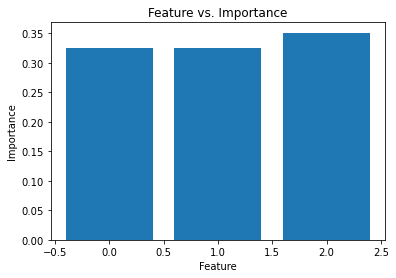

In [30]:
nums_bal = {}
pred_feat_names_bal = []
# define the model
model_bal = RandomForestClassifier()
# fit the model
model_bal.fit(scaled_X_train, y_train)

# get importance
importance_bal = model_bal.feature_importances_

y_pred_bal_2000_fs=model_bal.predict(scaled_X_test)

f1_Score = f1_score(y_test, y_pred_bal_2000_fs, average='macro')

print("F1 Score: ", f1_Score)

# summarize feature importance
for i,v in enumerate(importance_bal):
    nums_bal[i] = v

print('Top 3 predictive features...')

for x in range(0,3):
    max_key = max(nums_bal, key=nums_bal.get)
    colname = X_train.columns[max_key]
    pred_feat_names_bal.append(colname)
    print(colname)
    del nums_bal[max_key]

# plot feature importance
pyplot.bar([x for x in range(len(importance_bal))], importance_bal)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature vs. Importance')
pyplot.show()

In [31]:
pred_proba = model_bal.predict_proba(scaled_X_test)
auc_score1 = roc_auc_score(y_test, pred_proba[:,1])
print('Auc score: ',auc_score1)

Auc score:  0.8364233011291834


--- 
## Results Analysis 

From our statistical analysis and models, it can be assessed that the features that are most predictive are the ones that deal with perceived exertion, success, and recovery. As a result, this lines up with our hypothesis; therefore, we can accept our original hypothesis that the greater the perceived exertion an athlete reports, the higher the probability that later training sessions result in injury.

One thing we could do to improve our analysis is to run a model on the week data set (separate from the one we used). This contains even more features, so we could use our current random forest model and run it with that data set. From there, we could see if the same 'perceived' features are still predictive. We could also improve our analysis by talking with subject matter experts, so we can truly understand how our most predictive features could impact an athlete from their perspective. 

As far as lessons learned, we certainly gained meaningful experience when it came to creating our model. At first, numerous types of classification models were getting the same accuracy. Originally, we thought this was because the most correlated features were extremely linearly separable, but it was later found out that it was due to an unbalanced data set, where ~98% of the entries were non-injuries. This led to a poor model, so we learned how to overcome this by creating a balanced training/testing set with SMOTE. 

Overall, this project allowed for true hands-on experience with taking a data set we haven't seen before and creating meaningful analysis. While previous labs moreso guided us through the data set, this truly tested our knowledge and allowed for a greater learning experience.
